# Knowledge Graph

Knowledge graph (KG) represents the real world knowledge in a structured form. KG can be denoted as a set of triples of the form ⟨subject, relation, object⟩. There are three main tasks can be seen in KG, namely:

1. knowledge graph embedding (KGE), 
2. knowledge graph completion (KGC),
3. Knowledge Graph Alignment (KGA). 

KGE aims to map entities and relations into low-dimensional vectors, which usually regarded as the sub-task in KGC and KGA. The purpose of KGC is to predict new triples on the basis of existing triples, so as to further extend KGs. KGC is usually considered as a link prediction task. KGA aims at finding corresponding nodes or edges referring to the same entity or relationship in different knowledge graphs. KGA, such as cross-lingual knowledge graphs alignment, is useful for constructing more complete and compact KGs.

# Import Dependencies and Modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os #creating and removing a directory (folder), fetching its contents, changing and identifying the current directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wiki-sentences-v2/wiki_sentences_v2.csv


In [2]:
import spacy # A multitasking (tagging, parsing, named entity recognition, text classification and more) Statistical Model
nlp=spacy.load('en_core_web_sm') # A spaCy’s Statistical Models

In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx # Graph Plotting

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

**Sentence Segmentation**: The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object.

In [4]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [5]:
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


# Import Datasets

wiki_senences_v2 dataset is part of novels and collection of inter linked wiki data.

In [6]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/kaggle/input/imdb-dataset/IMDB Dataset.csv")
candidate_sentences.shape

(4318, 1)

In [7]:
candidate_sentences

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [8]:
df = candidate_sentences['sentence'].sample(5)
df

259                      themes or elements often prevalent in typical action-horror films
305                                                 all starred his wife, marina ladynina.
1193                                   pk was earlier scheduled to release on 6 june 2014.
3315    the square applicator is the more versatile than previously mentioned applicators.
4223                                          dangal performed particularly well in china.
Name: sentence, dtype: object

In [9]:
doc = nlp("the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books.")
for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
museum ... compound
collection ... nsubj
includes ... ROOT
37,000 ... nummod
film ... compound
titles ... dobj
, ... punct
60,000 ... nummod
posters ... conj
, ... punct
700,000 ... nummod
photographs ... conj
and ... cc
20,000 ... nummod
books ... conj
. ... punct


# Entity Extraction

Created a function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. Partitioned the code into multiple chunks for your convenience:

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]


Short Explanation for above chunking part:

**Chunk 1**

Defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

**Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token has a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

**Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

**Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

**Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [11]:
get_entities("the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books.")

['museum collection', '37,000 film titles']

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [12]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:37<00:00, 114.26it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [13]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', '-']]

# Relation / Predicate Extraction

In [14]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object
    matcher = Matcher(nlp.vocab)
    
    relation=[]
    
    # define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
    if len(matches)!=0: 
        k = len(matches) - 1 
        span = doc[matches[k][1]:matches[k][2]]
        return(span.text)
    
    else: 
        return None

In [15]:
get_entities("the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books.")

['museum collection', '37,000 film titles']

Let’s get the relations for all the Wikipedia sentences:

In [16]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:37<00:00, 114.97it/s]


In [35]:
candidate_sentences['sentence']

0                                                   confused and frustrated, connie decides to leave on her own.
1                                                              later, a woman’s scream is heard in the distance.
2                                                                       christian is then paralyzed by an elder.
3                                                                                     the temple is set on fire.
4                                                                              outside, the cult wails with him.
                                                          ...                                                   
4313       confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent.
4314                                               and le parisien gave the film their highest five-star rating.
4315    the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs a

Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [17]:
pd.Series(relations).value_counts()[:50]
print(pd.Series(relations).value_counts()[:50])

is               365
was              299
released on       88
are               78
include           72
were              68
released          41
composed by       33
's                32
have              31
has               30
became            30
become            28
released in       27
included          22
produced          21
made              20
been              20
had               19
called            19
considered        18
used              18
be                17
written by        15
received          15
scheduled         15
hired             14
stars             14
produced by       13
began             13
directed by       13
introduced in     13
went              13
wanted            12
began in          11
wrote             11
won               11
sold              10
set               10
gave              10
includes          10
gives              9
cast as            9
opened             9
produced in        9
shot in            9
used in            9
known as     

# Build a Knowledge Graph
We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [18]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [19]:
kg_df.head()

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, “John eats pasta”:

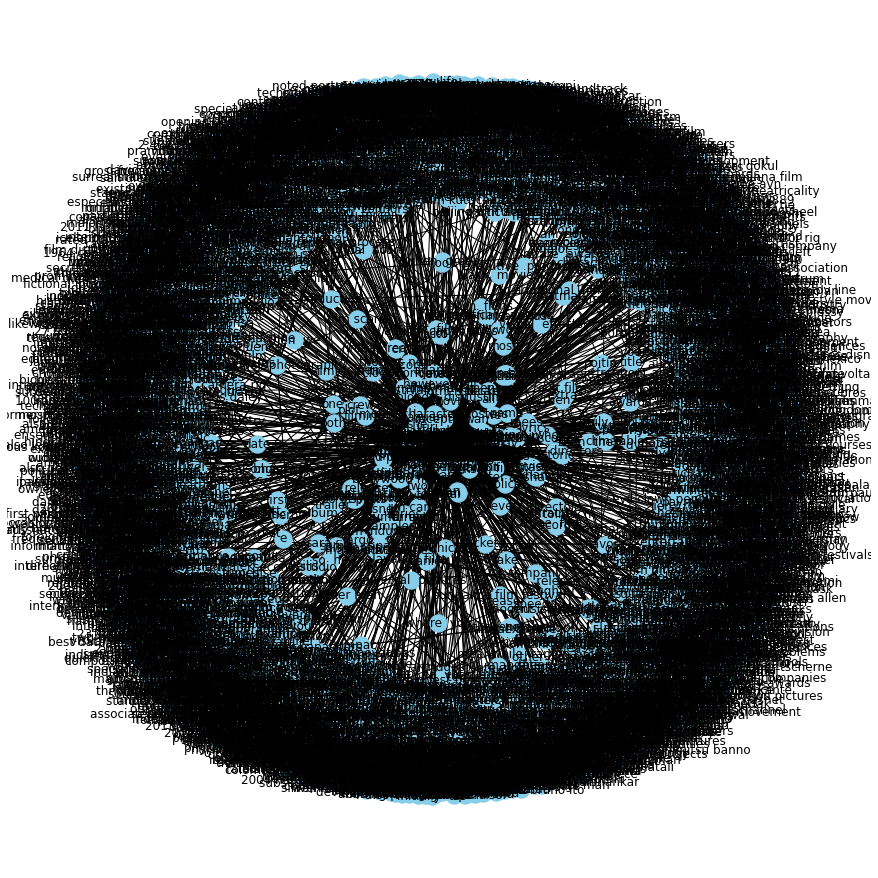

In [20]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!). It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates. So, it’s advisable to use only a few important relations to visualize a graph. Let's take one relation at a time. Let’s start with the relation “composed by”:

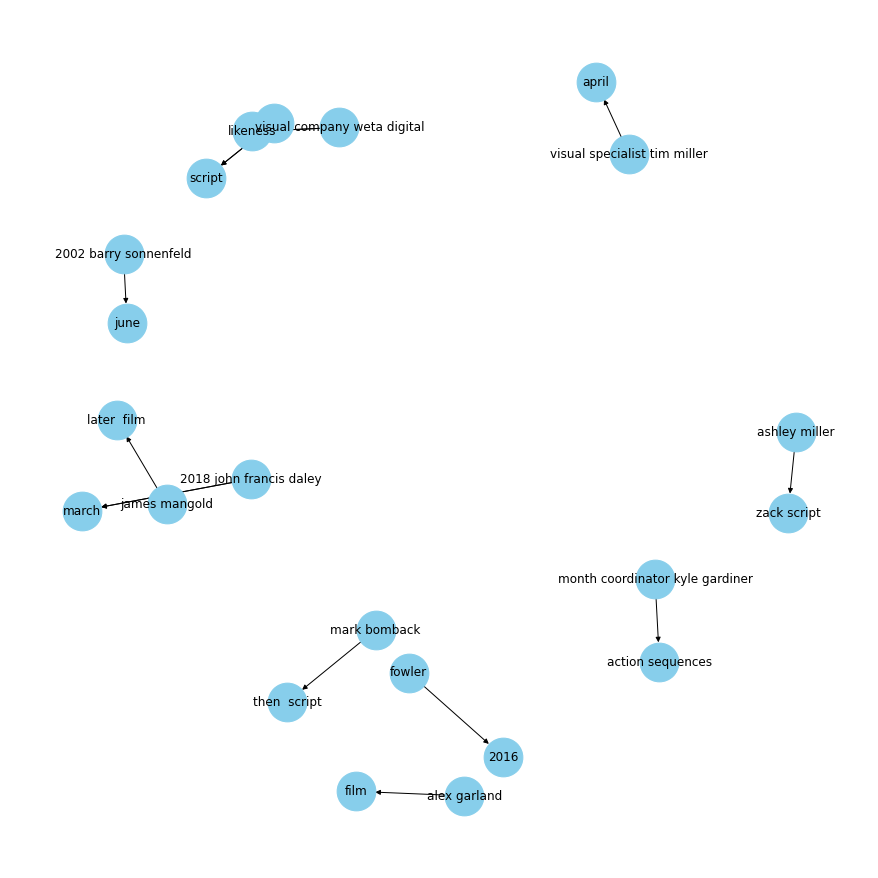

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="hired"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Let’s check out a few more relations. Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:

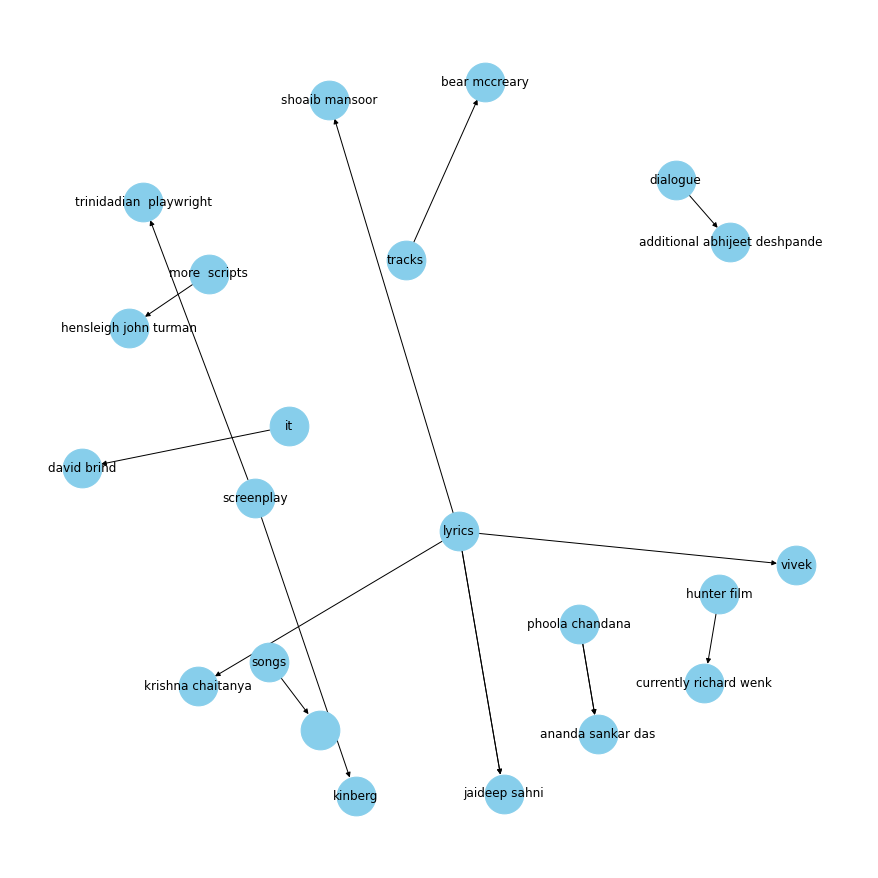

In [22]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Awesome! This knowledge graph is giving us some extraordinary information. Guys like Vivek, Krishna Chaitanya, and Jaideep are all famous lyricists and this graph beautifully captures this relationship. Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

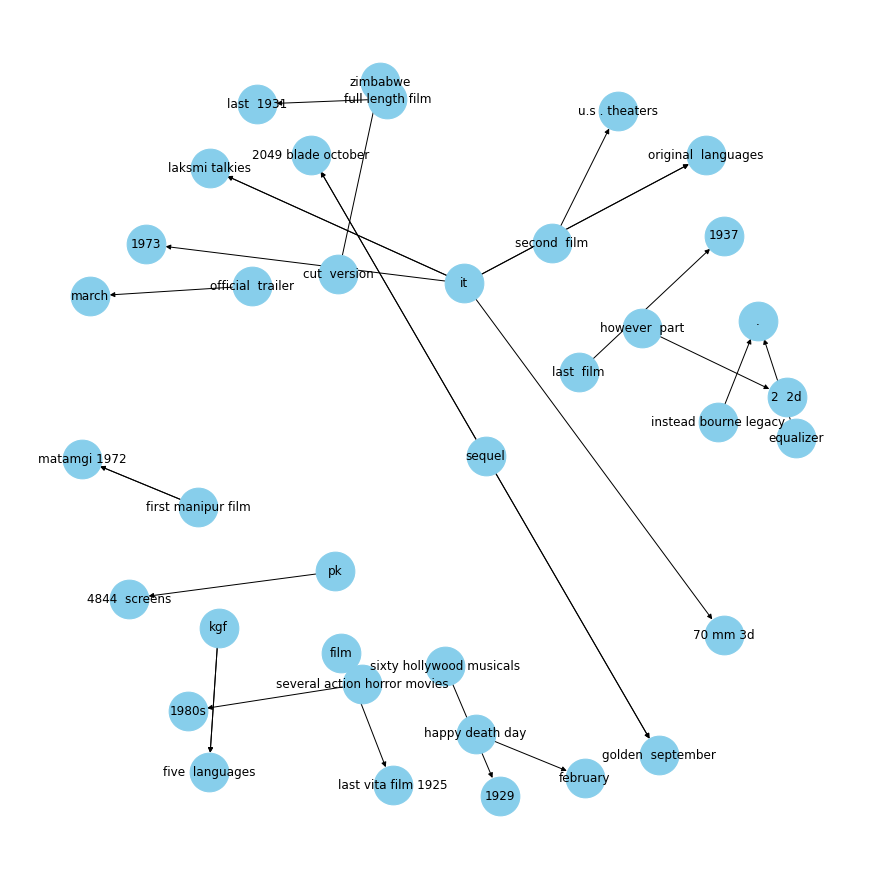

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s quite amazing!
Thank you for Reading!
Hope you got some knowledge!